# Lectura y graficación de la señal EEG capturada

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy.signal

## Abrimos los archivos txt para ver  el contenido

In [39]:
r = open("EEG_Reposo1.txt","r")
raw_data = r.readlines()[1]
r.close()
print(raw_data)


# {"98:D3:71:FD:62:1E": {"position": 0, "device": "bitalino_rev", "device name": "98:D3:71:FD:62:1E", "device connection": "BTH98:D3:71:FD:62:1E", "sampling rate": 1000, "resolution": [4, 1, 1, 1, 1, 10], "firmware version": 1282, "comments": "", "keywords": "", "mode": 0, "sync interval": 2, "date": "2023-9-29", "time": "10:30:32.317", "channels": [4], "sensor": ["EEGBITREV"], "label": ["A4"], "column": ["nSeq", "I1", "I2", "O1", "O2", "A4"], "special": [{}], "digital IO": [0, 0, 1, 1]}}



In [40]:
## Regex para extraer la frecuencia
x = re.findall("[0-5][0-9][0-9]\d", raw_data)[0]

print(x)

1000


In [41]:
Fs = float(x)
Ts=1/Fs # Determinar el periodo de muestreo

print(f" Fs={Fs} hz\n Ts={Ts} s")

 Fs=1000.0 hz
 Ts=0.001 s


## Leyendo el archivo excluyendo las primeras 3 filas

In [42]:
# Reemplazar con los archivos deseados
a_r = np.genfromtxt("EEG_Reposo1.txt", delimiter="\t",skip_header = 3)
a_p = np.genfromtxt("EEG_Parpadeo1.txt", delimiter="\t",skip_header = 3)
a_l = np.genfromtxt("EEG_Reposo2.txt", delimiter="\t",skip_header = 3)
a_c = np.genfromtxt("EEG_Calculo1.txt", delimiter="\t",skip_header = 3)

## Ploteamos la lectura

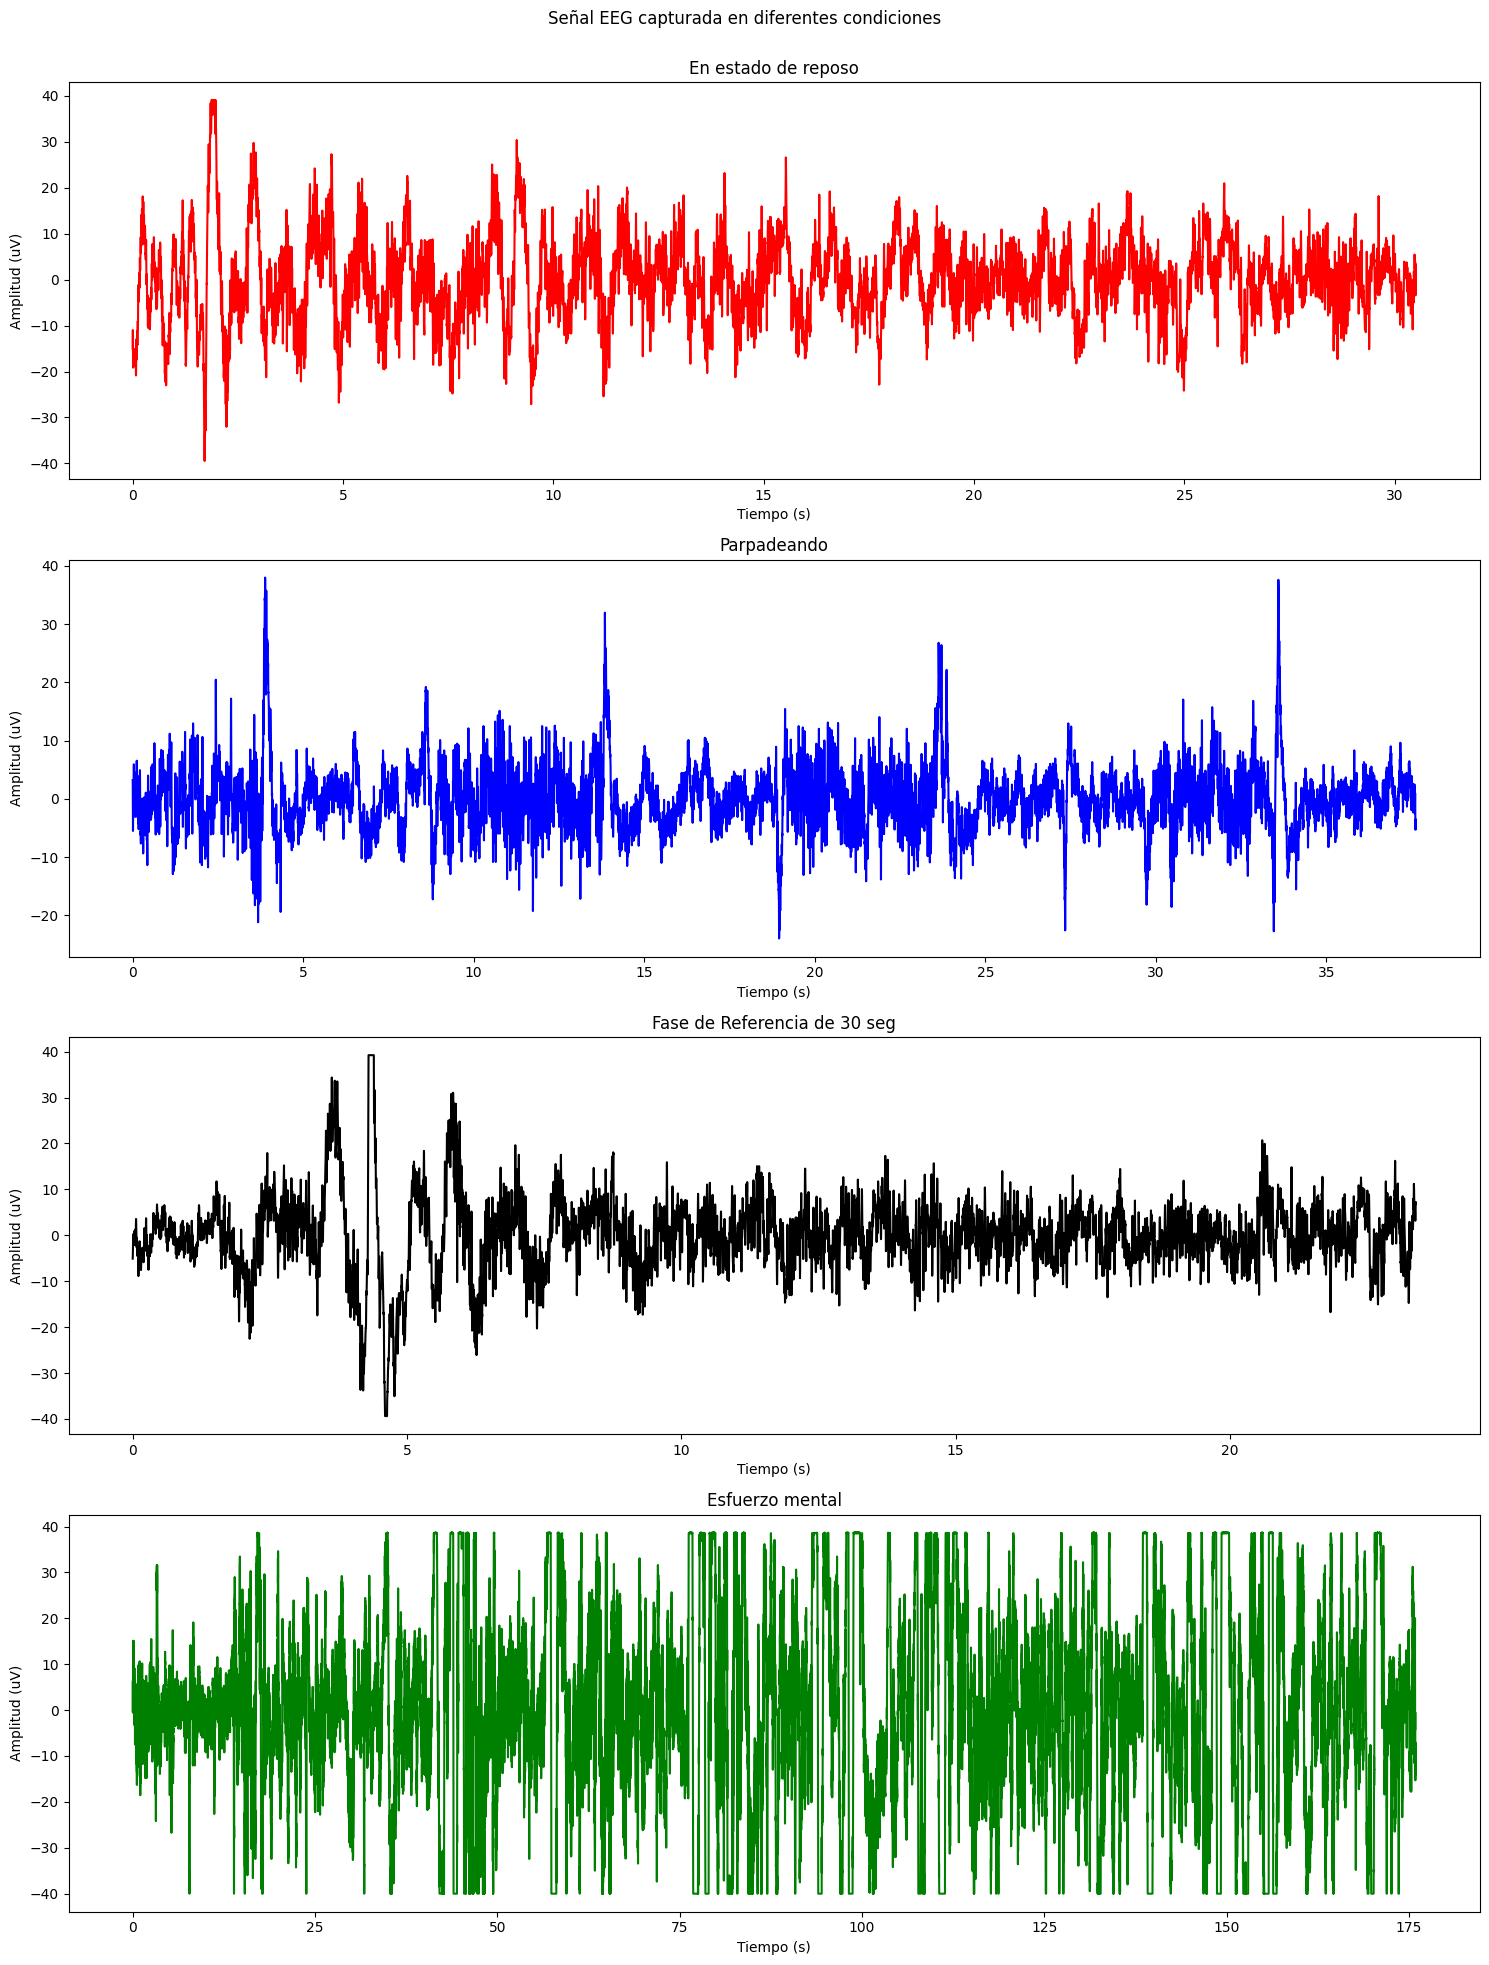

In [43]:
import scipy.signal as signal

bits = 10 # Bits de la salida 
volt_range = 78.98 #Rango de voltaje en milivoltios (-39.49; 39.49) uV
# Extraer la penultima columna (datos)
y_1 = (a_r[: ,-2] * volt_range/(2**bits - 1)) # convertir los bits a mV
y_1 = y_1 - np.mean(y_1) # Centrar la señal, ya que va de -1.64 a 1.64
t_1 = np.arange(0, len(y_1)*Ts, Ts) # Crear vector de tiempo considerando periodo de muestreo

y_2 = (a_p[: ,-2] * volt_range/(2**bits - 1))
y_2 = y_2 - np.mean(y_2)
t_2 = np.arange(0, len(y_2)*Ts, Ts)

y_3 = (a_l[: ,-2] * volt_range/(2**bits - 1))
y_3 = y_3 - np.mean(y_3)
t_3 = np.arange(0, len(y_3)*Ts, Ts)

y_4 = (a_c[: ,-2] * volt_range/(2**bits - 1))
y_4 = y_4 - np.mean(y_4)
t_4 = np.arange(0, len(y_4)*Ts, Ts)

fig2 = plt.figure(figsize=(15,20))
fig2.suptitle('Señal EEG capturada en diferentes condiciones\n\n')


plt.subplot(4, 1, 1); plt.plot(t_1, y_1, "r"); plt.xlabel("Tiempo (s)"); plt.title("En estado de reposo");
plt.ylabel("Amplitud (uV)");
plt.subplot(4, 1, 2); plt.plot(t_2, y_2, "b"); plt.xlabel("Tiempo (s)"); plt.title("Parpadeando");
plt.ylabel("Amplitud (uV)");
plt.subplot(4, 1, 3); plt.plot(t_3 , y_3, "k"); plt.xlabel("Tiempo (s)"); plt.title("Fase de Referencia de 30 seg")
plt.ylabel("Amplitud (uV)");
plt.subplot(4, 1, 4); plt.plot(t_4 , y_4, "g"); plt.xlabel("Tiempo (s)"); plt.title("Esfuerzo mental")
plt.ylabel("Amplitud (uV)");
fig = plt.gcf()
plt.tight_layout()
fig.set_facecolor('white')
plt.savefig('complete_signal.png', transparent=False, )
plt.show()


## Dominio de la frecuencia

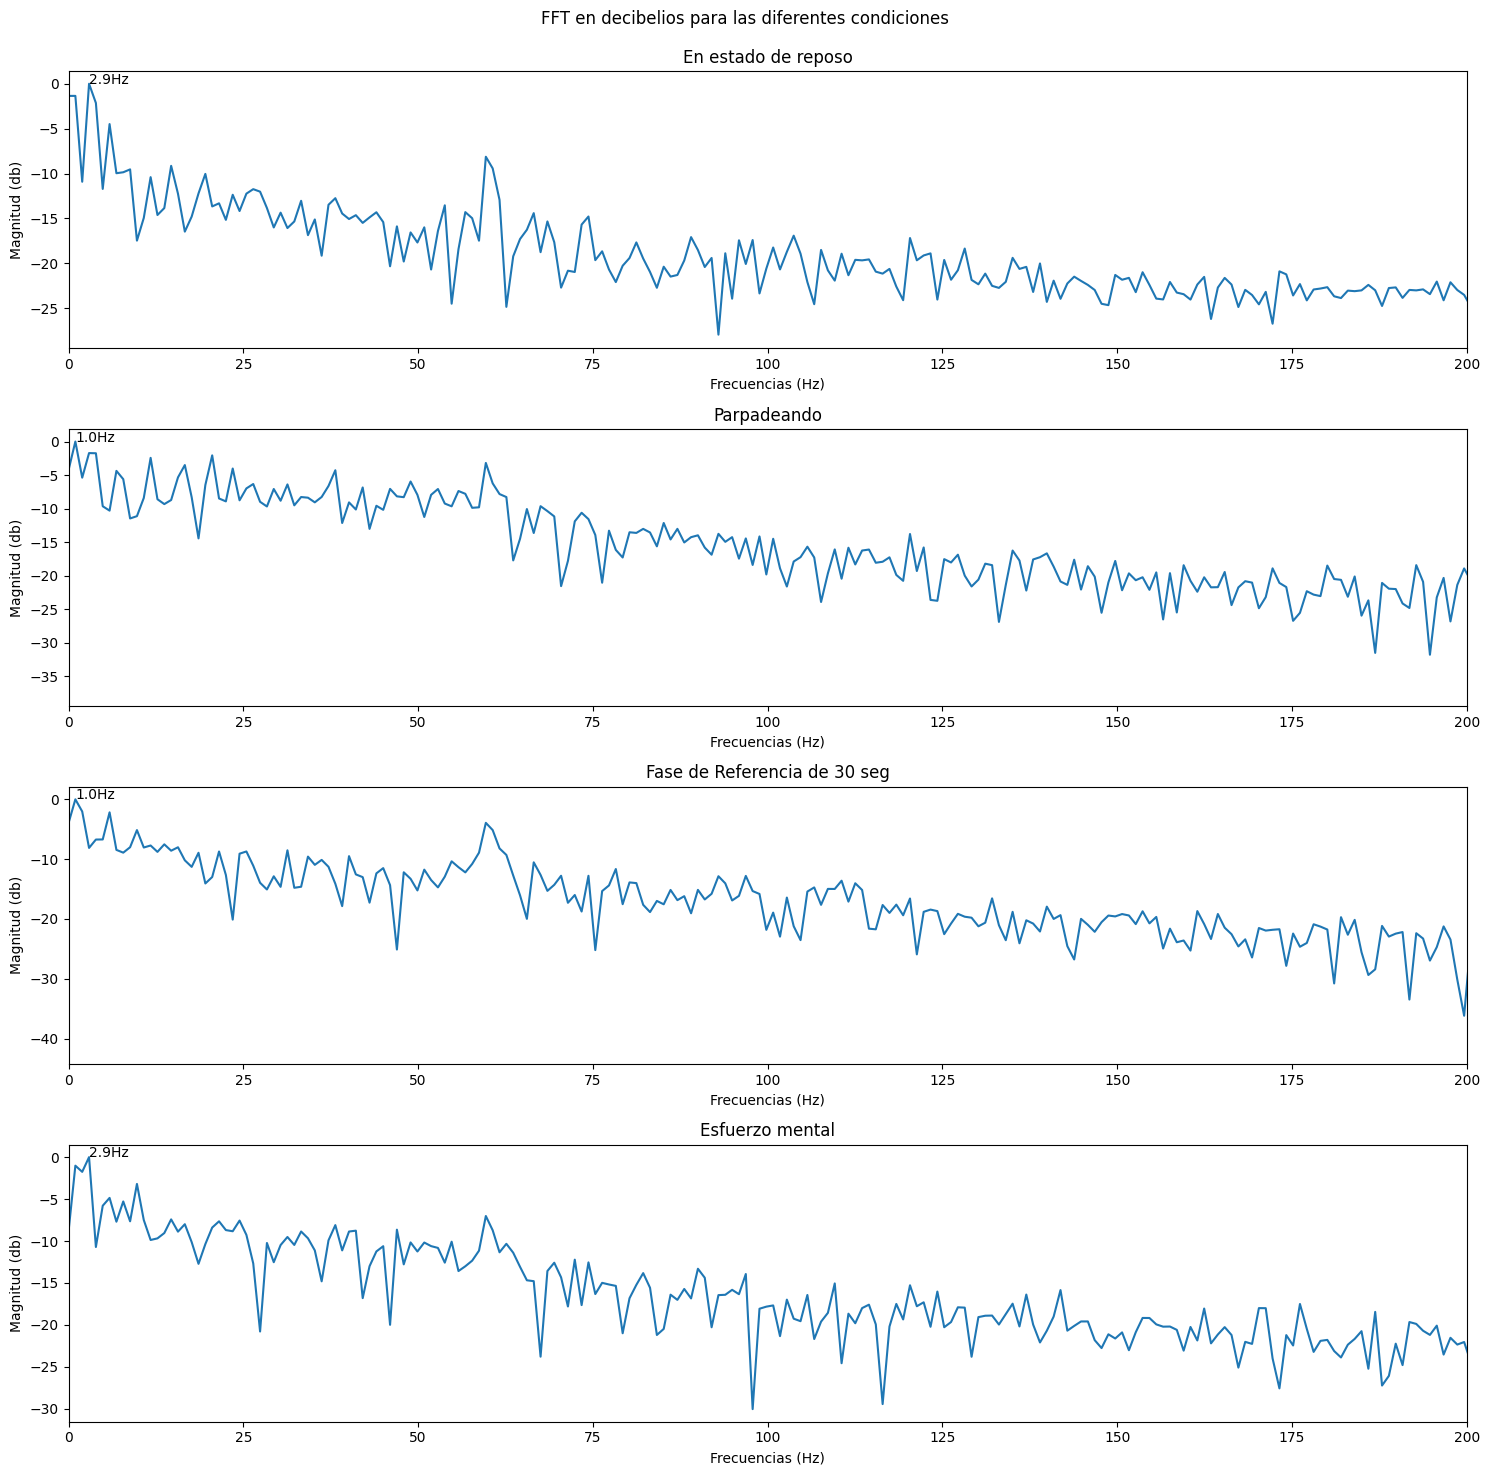

In [44]:

def determine_fft(y):
    N = 2**bits                                    

    signal1 = y

    signal_fft = np.fft.fft(signal1, N)           # fft magtinud
    signal_fft = np.round(np.abs(signal_fft),3)[0:N//2] # nos quedamos con los componente de la derecha de la FFT
    signal_aux = signal_fft/signal_fft.max()     # hallamos el maximo para pasar la magnitud a escala db

    with np.errstate(divide='ignore'):
        signal_fft_db = 10*np.log10(signal_aux)  

    F_list = np.linspace(0,Fs/2, N//2)
    F = np.round(F_list[np.argmax(signal_fft_db)], 1)  
    return F_list, signal_fft_db, F

F_list1, signal_fft_db1, F1 = determine_fft(y_1)
F_list3, signal_fft_db3, F3 = determine_fft(y_3)
F_list2, signal_fft_db2, F2 = determine_fft(y_2)
F_list4, signal_fft_db4, F4 = determine_fft(y_4)


fig2 = plt.figure(figsize=(15,15))
fig2.suptitle('FFT en decibelios para las diferentes condiciones\n')
#fig.set_facecolor('white')
plt.subplot(4, 1, 1); plt.plot(F_list1, signal_fft_db1); plt.xlabel("Frecuencias (Hz)"); plt.title("En estado de reposo");
plt.ylabel("Magnitud (db)");plt.xlim([0,200]);plt.text(F1,0, f"{F1}Hz")
plt.subplot(4, 1, 2); plt.plot(F_list2, signal_fft_db2); plt.xlabel("Frecuencias (Hz)"); plt.title("Parpadeando");
plt.ylabel("Magnitud (db)");plt.xlim([0,200]);plt.text(F2,0, f"{F2}Hz")
plt.subplot(4, 1, 3); plt.plot(F_list3, signal_fft_db3); plt.xlabel("Frecuencias (Hz)"); plt.title("Fase de Referencia de 30 seg")
plt.ylabel("Magnitud (db)");plt.xlim([0,200]);plt.text(F3,0, f"{F3}Hz")
plt.subplot(4, 1, 4); plt.plot(F_list4, signal_fft_db4); plt.xlabel("Frecuencias (Hz)"); plt.title("Esfuerzo mental")
plt.ylabel("Magnitud (db)");plt.xlim([0,200]);plt.text(F4,0, f"{F4}Hz")
fig = plt.gcf()
plt.tight_layout()
fig.set_facecolor('white')
plt.savefig('fft_signal.png', transparent=False, )
plt.show()


### Filtrado

In [45]:
import biosignalsnotebooks as bsnd

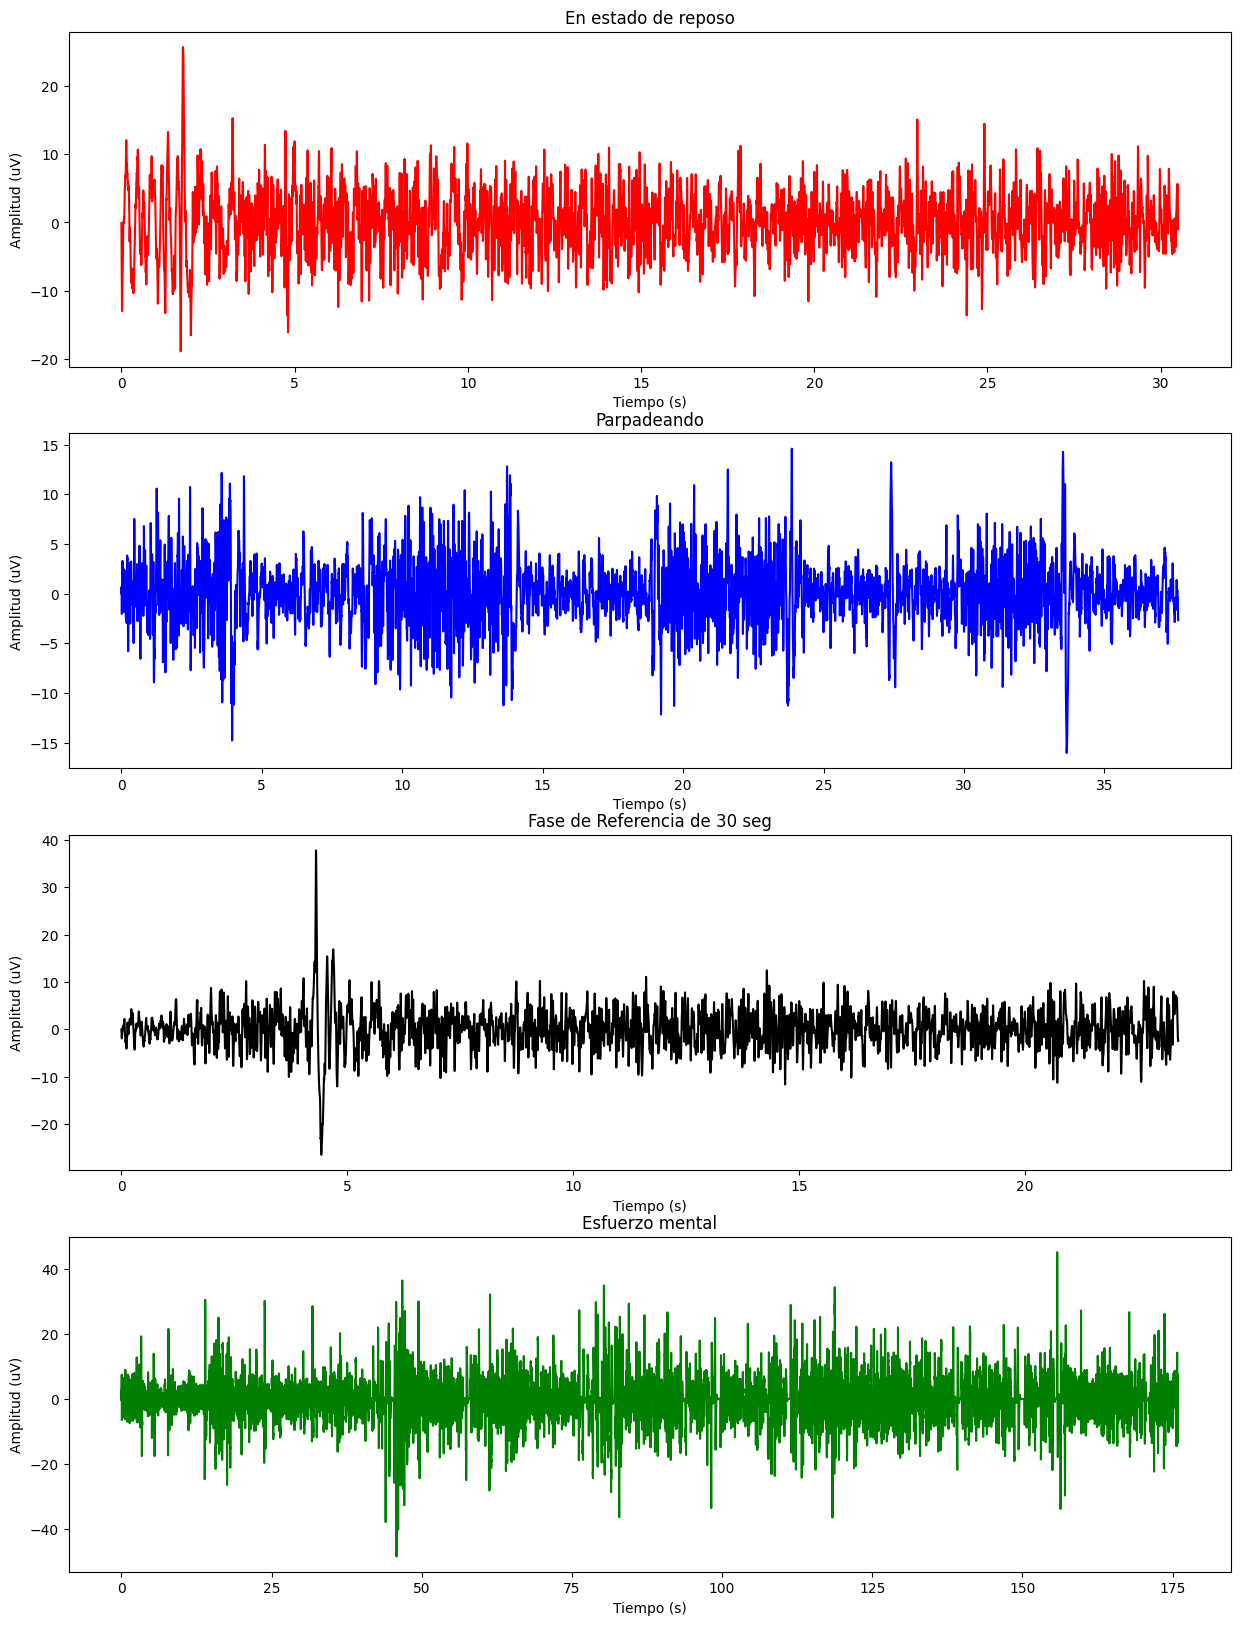

In [46]:
#Frecuencia de corte 
low_cuttoff_wide = 3
high_cutoff_wide = 30

Filt_signal_y1 = bsnd.bandpass(y_1, low_cuttoff_wide, high_cutoff_wide, order=2, fs=1000)
Filt_signal_y2 = bsnd.bandpass(y_2, low_cuttoff_wide, high_cutoff_wide, order=2, fs=1000)
Filt_signal_y3 = bsnd.bandpass(y_3, low_cuttoff_wide, high_cutoff_wide, order=2, fs=1000)
Filt_signal_y4 = bsnd.bandpass(y_4, low_cuttoff_wide, high_cutoff_wide, order=2, fs=1000)



fig2 = plt.figure(figsize=(15,20))

plt.subplot(4, 1, 1); plt.plot(t_1, Filt_signal_y1, "r"); plt.xlabel("Tiempo (s)"); plt.title("En estado de reposo");
plt.ylabel("Amplitud (uV)");
plt.subplot(4, 1, 2); plt.plot(t_2, Filt_signal_y2, "b"); plt.xlabel("Tiempo (s)"); plt.title("Parpadeando");
plt.ylabel("Amplitud (uV)");
plt.subplot(4, 1, 3); plt.plot(t_3 , Filt_signal_y3, "k"); plt.xlabel("Tiempo (s)"); plt.title("Fase de Referencia de 30 seg")
plt.ylabel("Amplitud (uV)");
plt.subplot(4, 1, 4); plt.plot(t_4 , Filt_signal_y4, "g"); plt.xlabel("Tiempo (s)"); plt.title("Esfuerzo mental")
plt.ylabel("Amplitud (uV)");



### Detección banda alfa

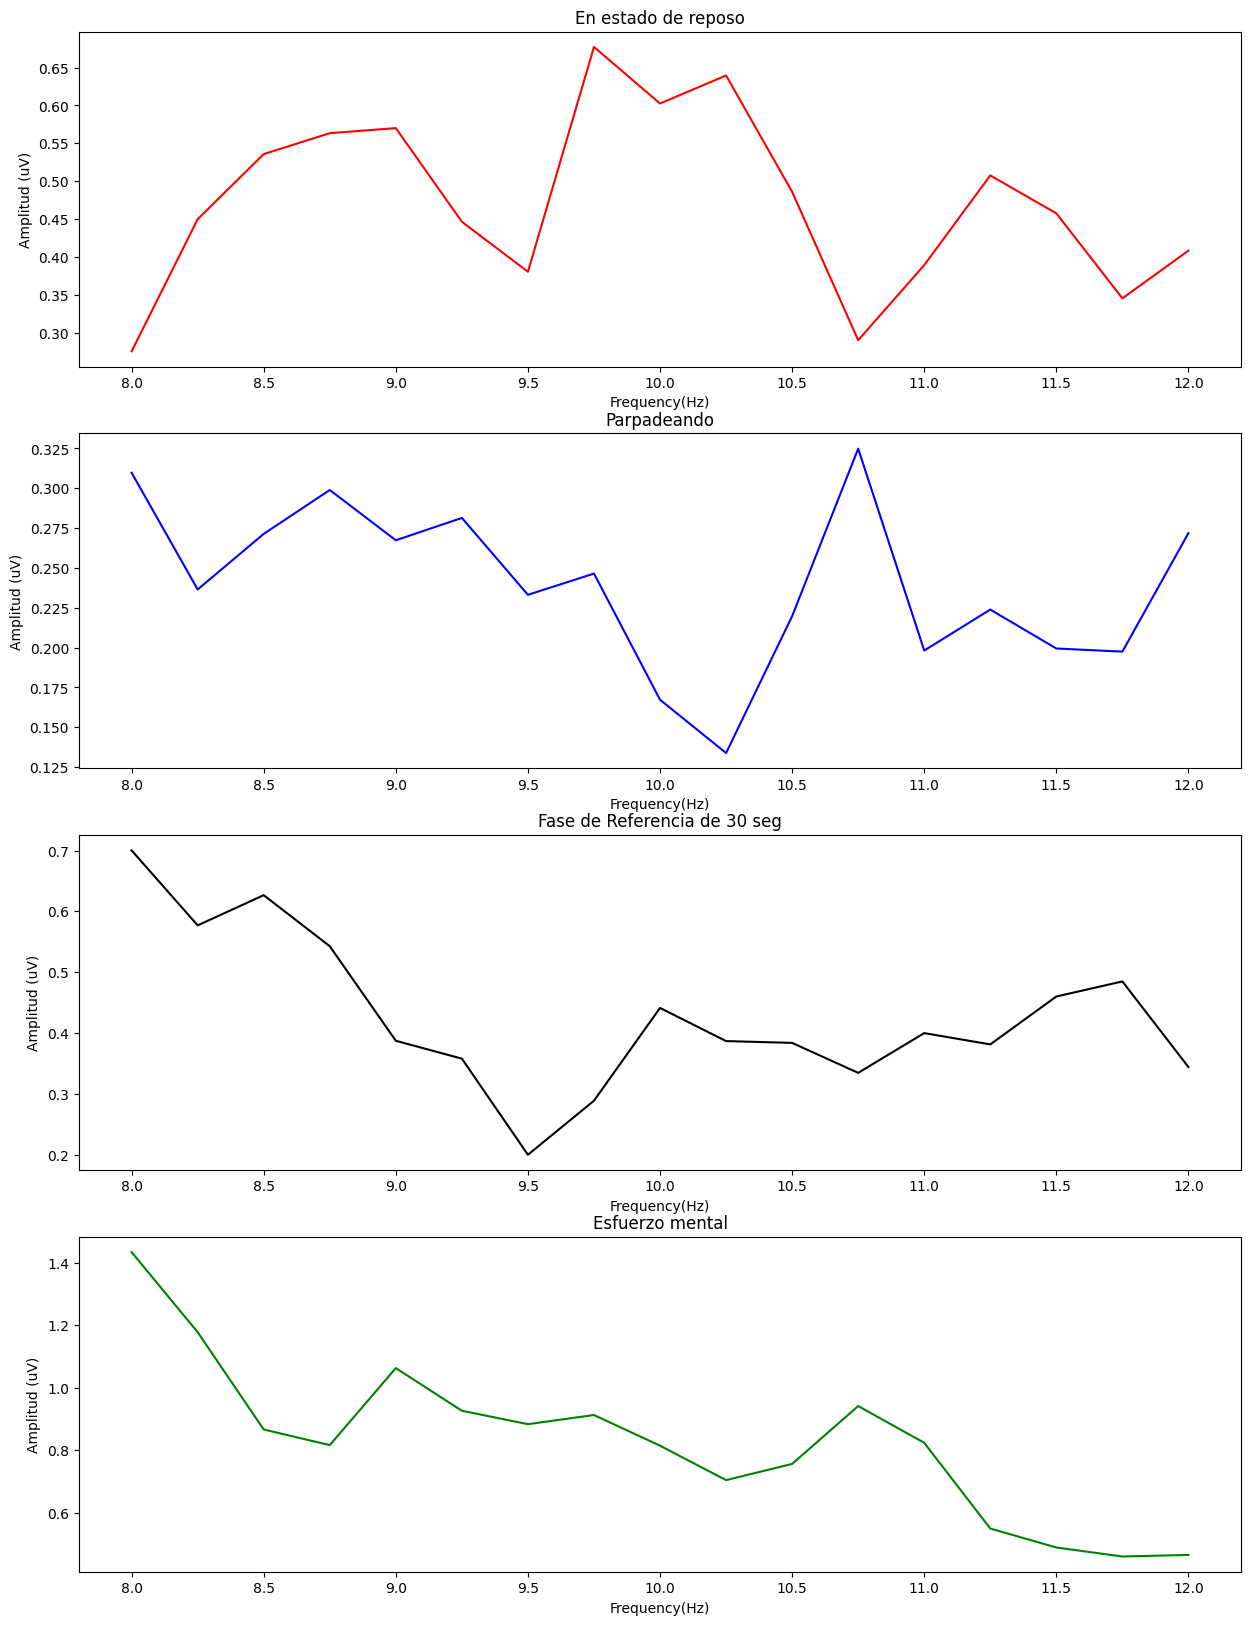

In [47]:
#Time Windows for Welchs method 
sr=1000
win = 4 * sr # 4 seconds time windows.

#FFT with time windows using scipy.signal.welch
axis_x_1, axis_y_1 = scipy.signal.welch(Filt_signal_y1, sr, nperseg=win)
axis_x_2, axis_y_2 = scipy.signal.welch(Filt_signal_y2, sr, nperseg=win)
axis_x_3, axis_y_3 = scipy.signal.welch(Filt_signal_y3, sr, nperseg=win)
axis_x_4, axis_y_4 = scipy.signal.welch(Filt_signal_y4, sr, nperseg=win)

freq_low = 8 #lower limit for alpha band
freq_high = 12 #Upper limit for alpha band 

Signal_1 = np.logical_and(axis_x_1 >= freq_low, axis_x_1 <= freq_high)
Signal_2 = np.logical_and(axis_x_2 >= freq_low, axis_x_2 <= freq_high)
Signal_3 = np.logical_and(axis_x_3 >= freq_low, axis_x_3 <= freq_high)
Signal_4 = np.logical_and(axis_x_4 >= freq_low, axis_x_4 <= freq_high)



fig2 = plt.figure(figsize=(15,20))

plt.subplot(4, 1, 1); plt.plot(axis_x_1[Signal_1], axis_y_1[Signal_1], "r"); plt.xlabel("Frequency(Hz)"); plt.title("En estado de reposo");
plt.ylabel("Amplitud (uV)");
plt.subplot(4, 1, 2); plt.plot(axis_x_2[Signal_2], axis_y_2[Signal_2], "b"); plt.xlabel("Frequency(Hz)"); plt.title("Parpadeando")
plt.ylabel("Amplitud (uV)");
plt.subplot(4, 1, 3); plt.plot(axis_x_3[Signal_3], axis_y_3[Signal_3], "k"); plt.xlabel("Frequency(Hz)"); plt.title("Fase de Referencia de 30 seg");
plt.ylabel("Amplitud (uV)");
plt.subplot(4, 1, 4); plt.plot(axis_x_4[Signal_4], axis_y_4[Signal_4], "g"); plt.xlabel("Frequency(Hz)"); plt.title("Esfuerzo mental")
plt.ylabel("Amplitud (uV)");